# 🤖 Notebook — Fine-tuning TinyBERT para Detecção de Fake News
## Ligia NLP Challenge — Deep Learning

| Informação | Detalhe |
|---|---|
| **Modelo** | `huawei-noah/TinyBERT_General_4L_312D` — 4 camadas, 312 hidden dims, ~14M parâmetros |
| **Tarefa** | Classificação binária (0 = Real, 1 = Fake) |
| **Entrada** | `data/raw/train.csv`, `data/raw/test.csv` |
| **Saída (modelos)** | `models/deeplearning/tinybert_checkpoints/` |
| **Saída (submissão)** | `data/processed/submission_tinybert.csv` |
| **Saída (figuras)** | `reports/figures/tinybert_*.png` |
| **Notebook anterior** | `4.0-predictions.ipynb` |

> ⚠️ **Hardware:** GPU fortemente recomendada (T4/V100).

---
### Execução Local (Jupyter)
Execute a partir da pasta `notebooks/`. Os paths `../models/` e `../data/` funcionam automaticamente.

### Execução no Google Colab
1. **Ative a GPU:** `Ambiente de execução` → `Alterar tipo de execução` → `T4 GPU`
2. Faça upload de `train.csv` e `test.csv`, ou monte o Google Drive:
   ```python
   from google.colab import drive
   drive.mount('/content/drive')
   DATA_DIR = "/content/drive/MyDrive/ligia-nlp-challenge/data/raw"
   ```
3. Ajuste os caminhos de saída de `../` para `/content/drive/MyDrive/ligia-nlp-challenge/`

---


## 1. Verificação de GPU e Instalação de Dependências

In [24]:
import subprocess, sys

# Verificar se GPU está disponível
gpu_check = subprocess.run(["nvidia-smi", "--query-gpu=name,memory.total", "--format=csv,noheader"],
                           capture_output=True, text=True)
if gpu_check.returncode == 0:
    print(f"✅ GPU detectada:\n{gpu_check.stdout.strip()}")
else:
    print("⚠️  GPU não encontrada. O treinamento será lento na CPU.")


✅ GPU detectada:
Tesla T4, 15360 MiB


In [25]:
# Instalação das dependências (apenas no Colab)
!pip install lime
!pip install transformers datasets accelerate -q
print("✅ Dependências instaladas!")


✅ Dependências instaladas!


In [26]:
import os
import re
import json
import warnings
import logging
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    AutoConfig
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer

In [22]:
# ─── CONFIGURAÇÕES GLOBAIS ────────────────────────────────────────────────────
SEED         = 42
MODEL_NAME   = "huawei-noah/TinyBERT_General_4L_312D"
NUM_LABELS   = 2
MAX_LEN      = 256     # chars → tokens (reduzido para caber na memória)
BATCH_SIZE   = 32     # reduza para 16 se der OOM
EPOCHS       = 12
LR           = 1e-5
WARMUP_RATIO = 0.2
WEIGHT_DECAY = 0.01
DROPOUT       = 0.2


print(f"Carregando tokenizador: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)
# ... resto do código
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"✅ Bibliotecas carregadas!")
print(f"   Transformers: {transformers.__version__}")
print(f"   PyTorch     : {torch.__version__}")
print(f"   Dispositivo : {DEVICE.upper()}")
if DEVICE == "cuda":
    print(f"   GPU         : {torch.cuda.get_device_name(0)}")
    print(f"   VRAM        : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Carregando tokenizador: huawei-noah/TinyBERT_General_4L_312D
✅ Bibliotecas carregadas!
   Transformers: 5.0.0
   PyTorch     : 2.10.0+cu128
   Dispositivo : CUDA
   GPU         : Tesla T4
   VRAM        : 15.6 GB


## 2. Carregamento dos Dados

> ⚠️ **Execute apenas UMA das duas células abaixo**, conforme seu ambiente:
> - **Célula A** → Google Colab (upload ou Google Drive)
> - **Célula B** → Execução local (`notebooks/` como diretório de trabalho)


In [27]:
# ─── CONFIGURAÇÃO DE CAMINHO ───────────────────────────────────────────────────
DATA_DIR = "."   # diretório raiz do Colab (após upload)

# Opção Google Drive (descomente se preferir):
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = "/content/drive/MyDrive/ligia-nlp-challenge/data/raw"

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

# carrega o dataset
df_train = pd.read_csv(TRAIN_PATH, engine='python', on_bad_lines='skip')
df_test  = pd.read_csv(TEST_PATH, engine='python', on_bad_lines='skip')

print(f"Train : {df_train.shape}  |  Colunas: {list(df_train.columns)}")
print(f"Test  : {df_test.shape}   |  Colunas: {list(df_test.columns)}")
print(f"\nDistribuição de classes:\n{df_train['label'].value_counts()}")
df_train.head(3)

Train : (22844, 6)  |  Colunas: ['id', 'title', 'text', 'subject', 'date', 'label']
Test  : (5712, 5)   |  Colunas: ['id', 'title', 'text', 'subject', 'date']

Distribuição de classes:
label
0    17133
1     5711
Name: count, dtype: int64


,id,title,text,subject,date,label
0,13355,"Exclusive: Pentagon, Lockheed near deal on $9 ...",WASHINGTON (Reuters) - The U.S. Department of ...,politicsNews,"January 19, 2017",0
1,2113,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...,HILL larious! If this was a Donald Trump pi a...,left-news,"Aug 3, 2016",1
2,27667,Philippine leader says 'no way' he'll do deal ...,MANILA (Reuters) - Philippine President Rodrig...,worldnews,"September 9, 2017",0


In [ ]:

DATA_DIR = "../data/raw"

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

assert os.path.exists(TRAIN_PATH), f"Arquivo não encontrado: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH),  f"Arquivo não encontrado: {TEST_PATH}"

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print(f"✅ [LOCAL] Dados carregados de: {os.path.abspath(DATA_DIR)}")
print(f"   Train : {df_train.shape}  |  Colunas: {list(df_train.columns)}")
print(f"   Test  : {df_test.shape}   |  Colunas: {list(df_test.columns)}")
print(f"\nDistribuição de classes:\n{df_train['label'].value_counts()}")
df_train.head(3)


## 3. Pré-processamento do Texto

In [28]:
def clean_text(text: str) -> str:
    """Limpeza leve: preserva pontuação e maiúsculas."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+", " ", text)   # remove URLs
    text = re.sub(r"<.*?>", " ", text)              # remove HTML
    text = re.sub(r"\s+", " ", text).strip()
    return text


def build_input(df: pd.DataFrame, max_chars: int = 1024) -> pd.Series:
    """Combina title e text com separador [SEP], truncando para max_chars."""
    title = df["title"].fillna("").apply(clean_text)
    text  = df["text"].fillna("").apply(clean_text).str[:max_chars]
    return title + " [SEP] " + text


df_train["input_text"] = build_input(df_train)
df_test["input_text"]  = build_input(df_test)

print(f"Exemplos de input (primeiros 200 chars):")
for i in range(2):
    print(f"\n[{i}] Label={df_train['label'].iloc[i]}")
    print(df_train["input_text"].iloc[i][:200])


Exemplos de input (primeiros 200 chars):

[0] Label=0
Exclusive: Pentagon, Lockheed near deal on $9 billion F-35 contract - sources [SEP] WASHINGTON (Reuters) - The U.S. Department of Defense and Lockheed Martin Corp (LMT.N) are close to deal for a contr

[1] Label=1
“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treated To “Hillary In Prison” Float…Water Balloon Passed Out To Throw At Her [SEP] HILL larious! If this was a Donald Trump pi ata, the media would be all ove


## 4. Tokenização com TinyBERT

O TinyBERT usa o mesmo tokenizador WordPiece do BERT original. A tokenização aplica:

$$\text{input} = [\text{CLS}] + \text{tokens}_{title} + [\text{SEP}] + \text{tokens}_{text} + [\text{SEP}]$$



In [29]:
print(f"Carregando tokenizador: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)
print(f"✅ Tokenizador carregado | Vocab size: {tokenizer.vocab_size}")

# Demonstração
sample = df_train["input_text"].iloc[0]
enc = tokenizer(sample, max_length=MAX_LEN, truncation=True)
print(f"\nExemplo de tokenização:")
print(f"  Texto (100 chars): {sample[:100]}")
print(f"  Nº de tokens     : {len(enc['input_ids'])}")
print(f"  Primeiros tokens : {tokenizer.convert_ids_to_tokens(enc['input_ids'][:15])}")

# ─── DISTRIBUIÇÃO DO COMPRIMENTO DOS TEXTOS ───────────────────────────────────
token_lengths = []
sample_size = min(500, len(df_train))
for txt in df_train["input_text"].sample(sample_size, random_state=SEED):
    ids = tokenizer(txt, truncation=False)["input_ids"]
    token_lengths.append(len(ids))

print(f"\nComprimento de tokens (amostra {sample_size}):")
print(f"  Mediana : {np.median(token_lengths):.0f}")
print(f"  Pct95   : {np.percentile(token_lengths, 95):.0f}")
print(f"  Max     : {np.max(token_lengths)}")
print(f"  → MAX_LEN={MAX_LEN} captura ~{(np.array(token_lengths) <= MAX_LEN).mean()*100:.1f}% dos textos")


Carregando tokenizador: huawei-noah/TinyBERT_General_4L_312D
✅ Tokenizador carregado | Vocab size: 30522

Exemplo de tokenização:
  Texto (100 chars): Exclusive: Pentagon, Lockheed near deal on $9 billion F-35 contract - sources [SEP] WASHINGTON (Reut
  Nº de tokens     : 241
  Primeiros tokens : ['[CLS]', 'exclusive', ':', 'pentagon', ',', 'lockheed', 'near', 'deal', 'on', '$', '9', 'billion', 'f', '-', '35']

Comprimento de tokens (amostra 500):
  Mediana : 219
  Pct95   : 249
  Max     : 276
  → MAX_LEN=256 captura ~97.6% dos textos


In [18]:
nan_labels = df_train['label'].isnull().sum()
print(f"Número de valores NaN na coluna 'label': {nan_labels}")

if nan_labels > 0:
    print("\nIsso confirma que havia valores NaN na coluna 'label' antes da remoção.\nO `train_test_split` com `stratify=y` não consegue lidar com esses valores, por isso a linha `df_train = df_train.dropna(subset=['label'])` foi adicionada para resolver isso.")
else:
    print("Nenhum valor NaN encontrado na coluna 'label' (após a remoção, se já executado).")

Número de valores NaN na coluna 'label': 1

Isso confirma que havia valores NaN na coluna 'label' antes da remoção.
O `train_test_split` com `stratify=y` não consegue lidar com esses valores, por isso a linha `df_train = df_train.dropna(subset=['label'])` foi adicionada para resolver isso.


## 5. Preparação do Dataset

In [45]:
# ─── SPLIT TREINO / VALIDAÇÃO ─────────────────────────────────────────────────
# Remove rows with NaN in 'label' column
df_train = df_train.dropna(subset=['label'])

X = df_train["input_text"].values
y = df_train["label"].values

X_train_raw, X_val_raw, y_train_arr, y_val_arr = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)
print(f"Treino    : {len(X_train_raw)}")
print(f"Validação : {len(X_val_raw)}")
print(f"Teste     : {len(df_test)}")

# ─── FUNÇÃO DE TOKENIZAÇÃO ────────────────────────────────────────────────────
def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        max_length=MAX_LEN,
        truncation=True,
        padding=False,
    )

# ─── CRIAR HF DATASETS ────────────────────────────────────────────────────────
train_hf = HFDataset.from_dict({"text": X_train_raw.tolist(), "labels": y_train_arr.tolist()})
val_hf   = HFDataset.from_dict({"text": X_val_raw.tolist(),   "labels": y_val_arr.tolist()})
test_hf  = HFDataset.from_dict({"text": df_test["input_text"].tolist()})

train_hf = train_hf.map(tokenize_fn, batched=True, remove_columns=["text"], desc="Tokenizando treino")
val_hf   = val_hf.map(tokenize_fn,   batched=True, remove_columns=["text"], desc="Tokenizando validação")
test_hf  = test_hf.map(tokenize_fn,  batched=True, remove_columns=["text"], desc="Tokenizando teste")

train_hf.set_format("torch")
val_hf.set_format("torch")
test_hf.set_format("torch")

print(f"\n✅ Datasets criados!")
print(f"   Colunas treino: {train_hf.column_names}")
print(f"   Exemplo (shape input_ids): {train_hf[0]['input_ids'].shape}")

Treino    : 19417
Validação : 3427
Teste     : 5712


Tokenizando treino:   0%|          | 0/19417 [00:00<?, ? examples/s]

Tokenizando validação:   0%|          | 0/3427 [00:00<?, ? examples/s]

Tokenizando teste:   0%|          | 0/5712 [00:00<?, ? examples/s]


✅ Datasets criados!
   Colunas treino: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
   Exemplo (shape input_ids): torch.Size([222])


## 6. Carregamento do Modelo TinyBERT

O modelo usa **destilação de conhecimento** a partir do BERT-base para manter performance com muito menos parâmetros.


In [31]:
# ─── CARREGAR MODELO COM DROPOUT CUSTOMIZADO ──────────────────────────────────
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels    = NUM_LABELS,
    id2label      = {0: "Real", 1: "Fake"},
    label2id      = {"Real": 0, "Fake": 1},
    hidden_dropout_prob          = 0.1,   # dropout nas camadas ocultas
    attention_probs_dropout_prob = 0.1,   # dropout na atenção
    classifier_dropout           = 0.2,   # dropout extra antes do classificador
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config = config,
)
model = model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/71 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: huawei-noah/TinyBERT_General_4L_312D
Key                                        | Status     | 
-------------------------------------------+------------+-
fit_denses.{0, 1, 2, 3, 4}.bias            | UNEXPECTED | 
fit_denses.{0, 1, 2, 3, 4}.weight          | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not o

model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

## 7. Configuração e Treinamento com HuggingFace Trainer

In [48]:
# import shutil
# import os

# checkpoint_dir = './tinybert_checkpoints'
# final_model_dir = './tinybert_final'

# print(f"Tentando remover as pastas: {checkpoint_dir} e {final_model_dir}")

# if os.path.exists(checkpoint_dir):
#     try:
#         shutil.rmtree(checkpoint_dir)
#         print(f"✅ Pasta '{checkpoint_dir}' removida com sucesso.")
#     except OSError as e:
#         print(f"❌ Erro ao remover a pasta '{checkpoint_dir}': {e}")
# else:
#     print(f"⚠️ Pasta '{checkpoint_dir}' não encontrada. Nenhuma ação necessária.")

# if os.path.exists(final_model_dir):
#     try:
#         shutil.rmtree(final_model_dir)
#         print(f"✅ Pasta '{final_model_dir}' removida com sucesso.")
#     except OSError as e:
#         print(f"❌ Erro ao remover a pasta '{final_model_dir}': {e}")
# else:
#     print(f"⚠️ Pasta '{final_model_dir}' não encontrada. Nenhuma ação necessária.")

# print("Limpeza concluída. Agora você pode retreinar o modelo.")

Tentando remover as pastas: ./tinybert_checkpoints e ./tinybert_final
✅ Pasta './tinybert_checkpoints' removida com sucesso.
✅ Pasta './tinybert_final' removida com sucesso.
Limpeza concluída. Agora você pode retreinar o modelo.


In [49]:
# ─── FUNÇÃO DE MÉTRICAS ───────────────────────────────────────────────────────
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_macro": f1}


# ─── TRAINING ARGUMENTS ───────────────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir                  = "./tinybert_checkpoints",
    num_train_epochs            = EPOCHS,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size  = BATCH_SIZE * 2,
    learning_rate               = LR,
    weight_decay                = 0.01,
    warmup_ratio                = 0.1,
    lr_scheduler_type           = "cosine",
    label_smoothing_factor      = 0.1,
    eval_strategy               = "epoch",
    save_strategy               = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "f1_macro",
    greater_is_better           = True,
    logging_steps               = 50,
    fp16                        = (DEVICE == "cuda"),
    dataloader_num_workers      = 2,
    report_to                   = "none",
    seed                        = SEED,
    max_grad_norm               = 1.0,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_hf,
    eval_dataset    = val_hf,
    data_collator   = data_collator,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=4)],
)

print("✅ Trainer configurado!")
print(f"   Epochs            : {EPOCHS}")
print(f"   Batch size (treino): {BATCH_SIZE}")
print(f"   Learning rate     : {LR}")
print(f"   FP16 (GPU)        : {DEVICE == 'cuda'}")
print(f"\n   Steps por epoch   : {len(train_hf) // BATCH_SIZE}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


✅ Trainer configurado!
   Epochs            : 12
   Batch size (treino): 32
   Learning rate     : 1e-05
   FP16 (GPU)        : True

   Steps por epoch   : 606


In [50]:
# ─── TREINAMENTO ──────────────────────────────────────────────────────────────
print("🚀 Iniciando treinamento do TinyBERT...")

train_result = trainer.train()

print("\n✅ Treinamento concluído!")
print(f"   Tempo total    : {train_result.metrics['train_runtime']:.0f}s")
print(f"   Loss final     : {train_result.metrics['train_loss']:.4f}")
print(f"   Samples/seg    : {train_result.metrics['train_samples_per_second']:.1f}")


🚀 Iniciando treinamento do TinyBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.198732,0.201495,0.998833,0.998443
2,0.200240,0.202354,0.997957,0.997274
3,0.200548,0.201091,0.999125,0.998833
4,0.198714,0.202677,0.998541,0.998053
5,0.198706,0.202532,0.998541,0.998053
6,0.200131,0.211015,0.994456,0.992560
7,0.198698,0.201790,0.998833,0.998443


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias'].
There were unexpected keys in the checkp


✅ Treinamento concluído!
   Tempo total    : 455s
   Loss final     : 0.1994
   Samples/seg    : 512.3


In [51]:
trainer.save_model("./tinybert_final")
tokenizer.save_pretrained("./tinybert_final")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('./tinybert_final/tokenizer_config.json', './tinybert_final/tokenizer.json')

## 8. Avaliação na Validação

In [52]:
# ─── AVALIAÇÃO FINAL NA VALIDAÇÃO ────────────────────────────────────────────
eval_metrics = trainer.evaluate()
print("=== Métricas de Validação (melhor checkpoint) ===")
for k, v in eval_metrics.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# Predições detalhadas para o classification report
pred_output = trainer.predict(val_hf)
y_pred_val  = np.argmax(pred_output.predictions, axis=-1)
y_true_val  = np.array(y_val_arr)

print("\n=== Classification Report ===")
print(classification_report(y_true_val, y_pred_val, target_names=["Real", "Fake"]))


=== Métricas de Validação (melhor checkpoint) ===
  eval_loss: 0.2011
  eval_accuracy: 0.9991
  eval_f1_macro: 0.9988
  eval_runtime: 4.6509
  eval_samples_per_second: 736.8520
  eval_steps_per_second: 11.6110
  epoch: 7.0000

=== Classification Report ===
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      2570
        Fake       1.00      1.00      1.00       857

    accuracy                           1.00      3427
   macro avg       1.00      1.00      1.00      3427
weighted avg       1.00      1.00      1.00      3427



📊 Curvas salvas em: ../reports/figures/tinybert_training_curves.png


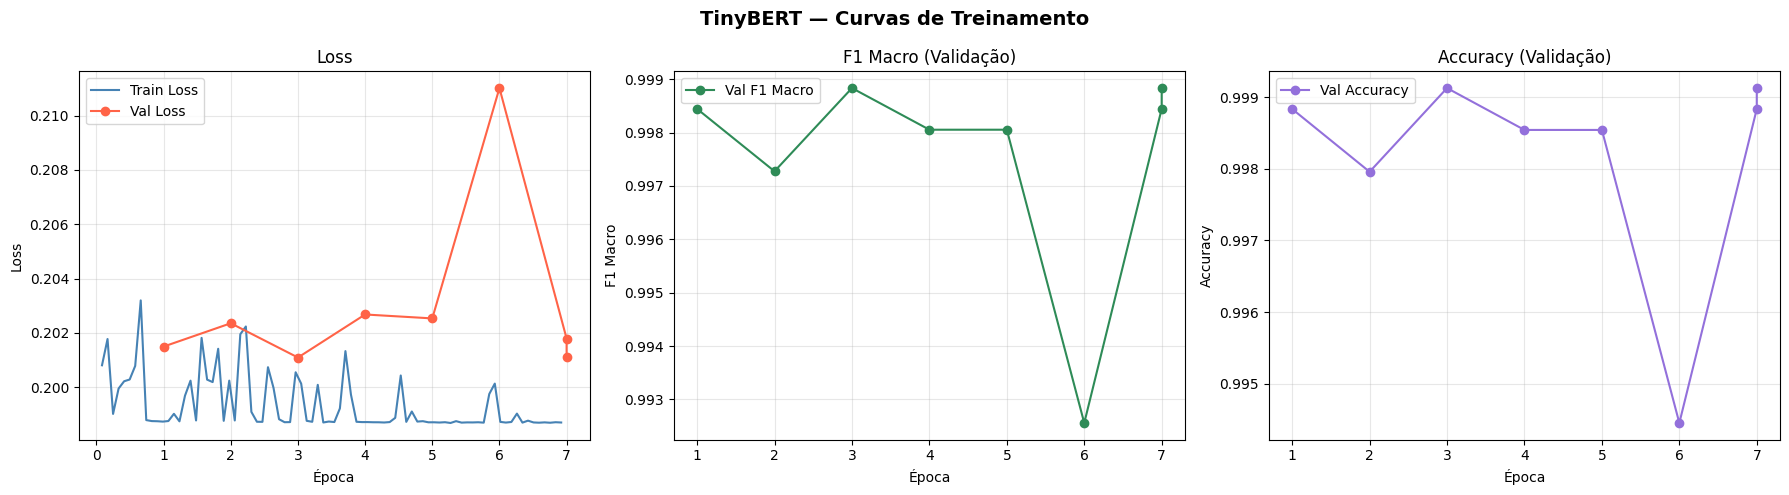

In [53]:
# ─── CURVAS DE TREINAMENTO ────────────────────────────────────────────────────
log_history = trainer.state.log_history

train_loss = [(h["epoch"], h["loss"])       for h in log_history if "loss" in h and "eval_loss" not in h]
eval_data  = [(h["epoch"], h["eval_loss"], h.get("eval_f1_macro", None), h.get("eval_accuracy", None))
              for h in log_history if "eval_loss" in h]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("TinyBERT — Curvas de Treinamento", fontsize=14, fontweight="bold")

# Loss
if train_loss:
    epochs_t, losses_t = zip(*train_loss)
    axes[0].plot(epochs_t, losses_t, label="Train Loss", color="steelblue")
if eval_data:
    epochs_e, eval_losses, eval_f1s, eval_accs = zip(*eval_data)
    axes[0].plot(epochs_e, eval_losses, label="Val Loss", color="tomato", marker="o")
axes[0].set_xlabel("Época"); axes[0].set_ylabel("Loss"); axes[0].set_title("Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# F1 Macro
if eval_data and eval_f1s[0] is not None:
    axes[1].plot(epochs_e, eval_f1s, color="seagreen", marker="o", label="Val F1 Macro")
    axes[1].set_xlabel("Época"); axes[1].set_ylabel("F1 Macro"); axes[1].set_title("F1 Macro (Validação)")
    axes[1].legend(); axes[1].grid(True, alpha=0.3)

# Accuracy
if eval_data and eval_accs[0] is not None:
    axes[2].plot(epochs_e, eval_accs, color="mediumpurple", marker="o", label="Val Accuracy")
    axes[2].set_xlabel("Época"); axes[2].set_ylabel("Accuracy"); axes[2].set_title("Accuracy (Validação)")
    axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()

FIGURES_DIR = "../reports/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)
fig_path = os.path.join(FIGURES_DIR, "tinybert_training_curves.png")
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
print(f"📊 Curvas salvas em: {fig_path}")
plt.show()


📊 Matriz de confusão salva em: ../reports/figures/tinybert_confusion_matrix.png


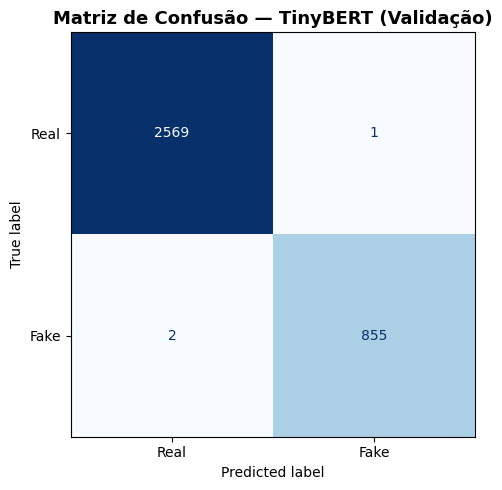

In [54]:
cm = confusion_matrix(y_true_val, y_pred_val)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(ax=ax, colorbar=False, cmap="Blues")
ax.set_title("Matriz de Confusão — TinyBERT (Validação)", fontsize=13, fontweight="bold")
plt.tight_layout()

FIGURES_DIR = "../reports/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)
cm_path = os.path.join(FIGURES_DIR, "tinybert_confusion_matrix.png")
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
print(f"📊 Matriz de confusão salva em: {cm_path}")
plt.show()


## 9. Geração de Predições para Submissão

In [55]:
# ─── PREDIÇÕES NO TESTE ───────────────────────────────────────────────────────
print("Gerando predições no conjunto de teste...")
test_output    = trainer.predict(test_hf)
y_test_pred    = np.argmax(test_output.predictions, axis=-1)
y_test_proba   = torch.softmax(torch.tensor(test_output.predictions), dim=-1).numpy()

submission = pd.DataFrame({
    "id":          df_test["id"],
    "label":       y_test_pred,
    "prob_real":   y_test_proba[:, 0].round(4),
    "prob_fake":   y_test_proba[:, 1].round(4),
})
submission_clean = submission[["id", "label"]]
submission_clean.to_csv("submission_tinybert.csv", index=False)

print(f"✅ Submission salva: submission_tinybert.csv")
print(f"\nDistribuição prevista:")
print(submission_clean["label"].value_counts().rename({0: "Real", 1: "Fake"}))
print(f"\nPrimeiras linhas:")
display(submission_clean.head())


Gerando predições no conjunto de teste...


✅ Submission salva: submission_tinybert.csv

Distribuição prevista:
label
Real    4280
Fake    1432
Name: count, dtype: int64

Primeiras linhas:


,id,label
0,5398,1
1,5503,1
2,23151,0
3,12669,0
4,27864,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Texto    : Obama surprises Vice President Biden with Medal of Freedom [SEP] WASHINGTON (Reuters) - U.S. President Barack Obama surp...
Predição : Real  (Real: 0.9541 | Fake: 0.0459)
Explicando classe: Real



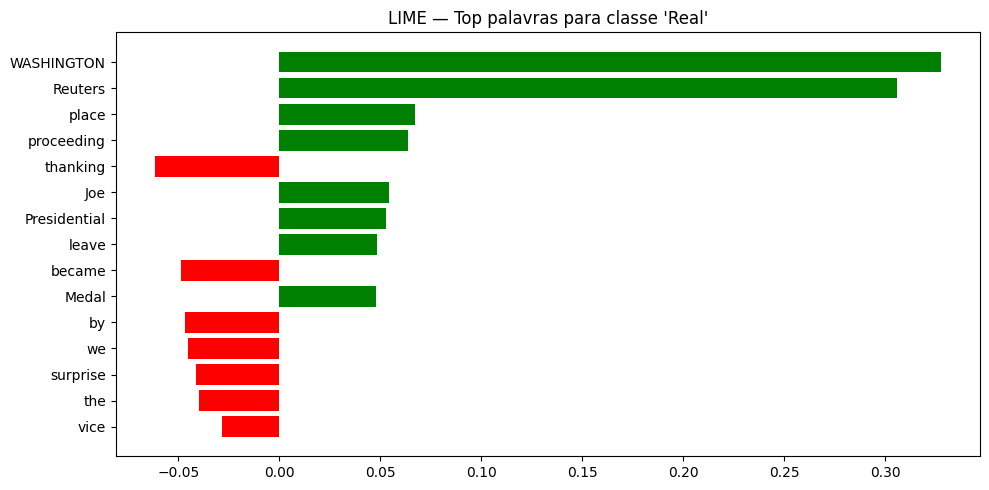

────────────────────────────────────────────────────────────────────────────────
Texto    : Restaurant Owner OBLITERATES Customer Who Said Woman’s Death Ruined Her New Year’s (IMAGES) [SEP] Working in the service...
Predição : Fake  (Real: 0.0458 | Fake: 0.9542)
Explicando classe: Fake



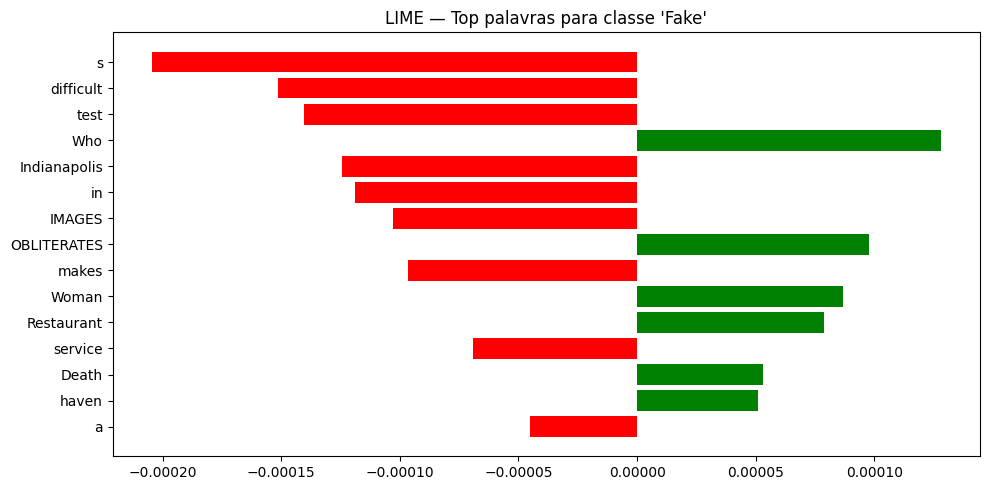

────────────────────────────────────────────────────────────────────────────────
Texto    : BOOM! 4 VENUES CANCEL KATHY GRIFFIN Appearances After She Blames Trump For Her Career Ending Decision To Pose With His S...
Predição : Fake  (Real: 0.0455 | Fake: 0.9545)
Explicando classe: Fake



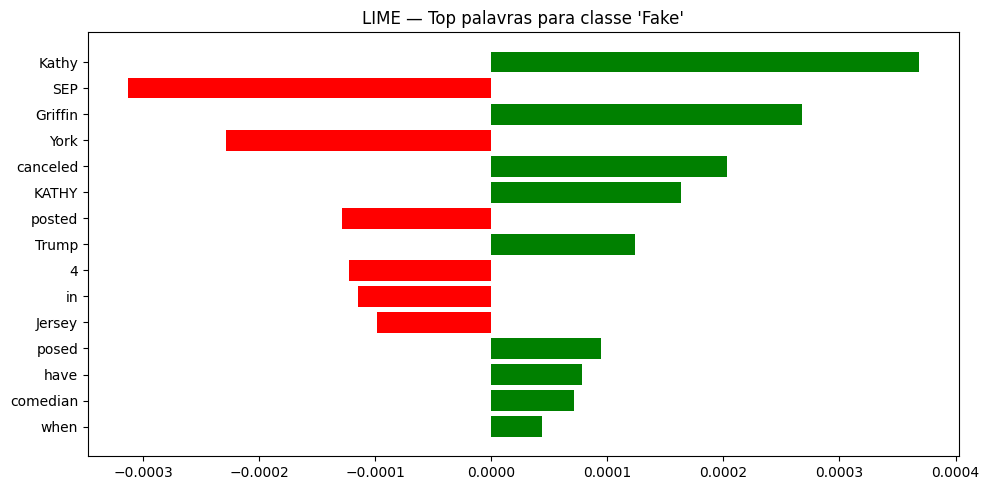

────────────────────────────────────────────────────────────────────────────────


In [56]:
# ─── FUNÇÃO DE PREDIÇÃO PARA O LIME ──────────────────────────────────────────
def predict_lime(texts):
    inputs = tokenizer(
        list(texts),
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding=True
    ).to(DEVICE)

    with torch.no_grad():
        logits = model(**inputs).logits

    return torch.softmax(logits, dim=-1).cpu().numpy()

# ─── EXPLAINER ────────────────────────────────────────────────────────────────
explainer_lime = LimeTextExplainer(
    class_names=["Real", "Fake"],
    split_expression=r"\W+",
    random_state=SEED
)

# ─── FUNÇÃO REUTILIZÁVEL ──────────────────────────────────────────────────────
def explain_lime(text, num_features=15, num_samples=500, label=None):
    proba = predict_lime([text])[0]
    pred_class = int(np.argmax(proba))
    class_names = ["Real", "Fake"]

    if label is None:
        label = pred_class

    exp = explainer_lime.explain_instance(
        text,
        predict_lime,
        num_features=num_features,
        num_samples=num_samples,
        labels=[label]
    )

    print(f"Texto    : {text[:120]}...")
    print(f"Predição : {class_names[pred_class]}  (Real: {proba[0]:.4f} | Fake: {proba[1]:.4f})")
    print(f"Explicando classe: {class_names[label]}\n")

    fig = exp.as_pyplot_figure(label=label)
    fig.set_size_inches(10, 5)
    plt.title(f"LIME — Top palavras para classe '{class_names[label]}'")
    plt.tight_layout()
    plt.show()

    return exp

# ─── TESTAR ───────────────────────────────────────────────────────────────────
for i in [0, 1, 2]:
    text = X_val_raw[i]
    explain_lime(text)
    print("─" * 80)


EXEMPLO — REAL (label=0)
Texto    : Obama surprises Vice President Biden with Medal of Freedom [SEP] WASHINGTON (Reuters) - U.S. President Barack Obama surp...
Predição : Real  (Real: 0.9552 | Fake: 0.0448)
Explicando classe: Real



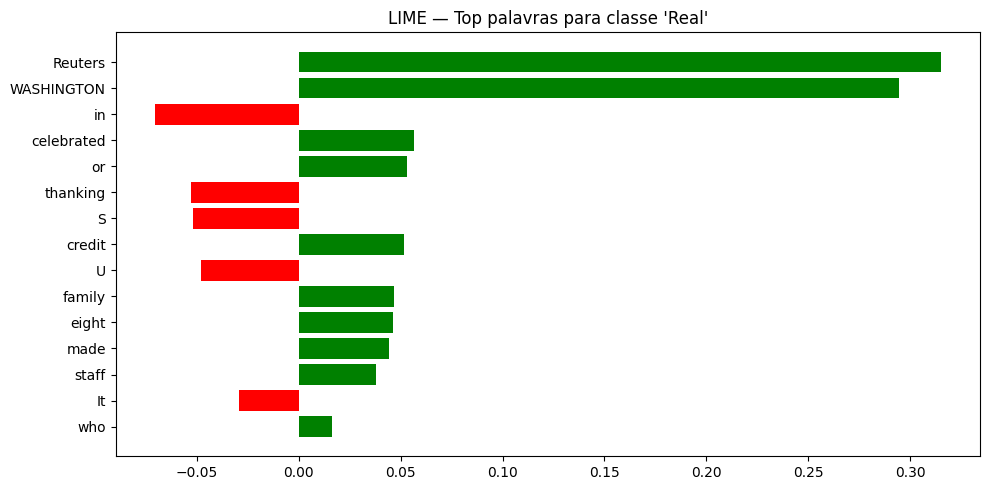

EXEMPLO — FAKE (label=1)
Texto    : Restaurant Owner OBLITERATES Customer Who Said Woman’s Death Ruined Her New Year’s (IMAGES) [SEP] Working in the service...
Predição : Fake  (Real: 0.0475 | Fake: 0.9525)
Explicando classe: Fake



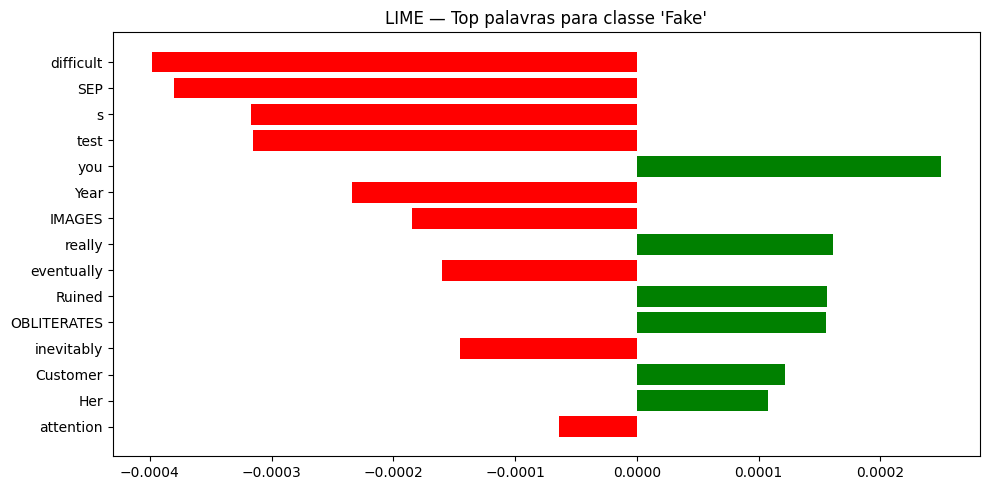

In [40]:
# ─── COMPARAÇÃO LIME: Real vs Fake ────────────────────────────────────────────
real_text = X_val_raw[y_val_arr == 0][0]
fake_text = X_val_raw[y_val_arr == 1][0]

print("=" * 80)
print("EXEMPLO — REAL (label=0)")
print("=" * 80)
explain_lime(real_text)

print("=" * 80)
print("EXEMPLO — FAKE (label=1)")
print("=" * 80)
explain_lime(fake_text)
